In [1]:
#  Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#  Import python wrapper for pitch-by-pitch data from MLB APIs
from pybaseball import statcast

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.linear_model import Lasso, ElasticNet, Ridge

In [3]:
from tensorflow.keras.layers import Dense

In [4]:
from tensorflow.keras.models import Sequential

In [5]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.metrics import AUC

In [6]:
#  Pull all pitches thrown in 2023 season so far
p_2022 = statcast(start_dt='2022-03-01', end_dt='2022-10-11')

This is a large query, it may take a moment to complete


C:\Users\ari\anaconda3\lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [03:09<00:00,  1.11it/s]


In [8]:
p_2023.to_csv('../data/2023.csv',index = False)

In [7]:
pitches = p_2022

In [10]:
#  Limit data to combinations where a pitcher has thrown a particular pitch at least 30 times
# pitches = pitches[pitches.groupby(['player_name','pitch_type']).transform('size') > 30]

In [8]:
#  View pitch outcome types
pitches['description'].value_counts()

ball                       252020
hit_into_play              138304
foul                       134292
called_strike              124743
swinging_strike             83806
blocked_ball                16629
foul_tip                     7419
swinging_strike_blocked      4791
hit_by_pitch                 2341
foul_bunt                    1132
missed_bunt                   223
pitchout                       40
bunt_foul_tip                  26
Name: description, dtype: int64

In [9]:
#  View pitch "event" outcomes 
#  Note:  almost all of these are subcategories of pitches['description'] == 'hit_into_pitch'
pitches['events'].value_counts()

field_out                       81432
strikeout                       45764
single                          28853
walk                            16205
double                           8981
home_run                         5982
force_out                        4214
grounded_into_double_play        3778
hit_by_pitch                     2341
field_error                      1356
sac_fly                          1350
triple                            731
double_play                       457
fielders_choice                   419
sac_bunt                          405
fielders_choice_out               310
caught_stealing_2b                236
strikeout_double_play             130
catcher_interf                     78
other_out                          35
sac_fly_double_play                23
pickoff_1b                         18
caught_stealing_home               13
caught_stealing_3b                 12
wild_pitch                          8
triple_play                         6
pickoff_3b  

In [10]:
#  View types of games
pitches['game_type'].value_counts()

R    708540
S     53346
F      2727
D      1153
Name: game_type, dtype: int64

In [11]:
#  Limit inquiry to regular season games
pitches = pitches[pitches['game_type'] == 'R']

In [12]:
#  Dummify pitching hand (1 for Left-handed, 0 for right-handed)
pitches['p_throws'] = pitches['p_throws'].apply(lambda x: 1 if x == 'L' else 0)

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\2960677010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['p_throws'] = pitches['p_throws'].apply(lambda x: 1 if x == 'L' else 0)


We create a feature to distinguish between starting and relief pitchers.  This is important because starting pitchers pitch less frequently, and therefore have longer stamina to remain in a game.  (For more background on the differences between starting and relief pitching, read the descriptions at https://www.mlb.com/glossary/positions/).  

<p>We can reliably identify starters based on the fact that relief pitchers almost never pitch in the 1st inning.  (We will accept the possibility that a pitcher otherwise fitting the profile of a relief pitcher could be mistakenly identified as a starter after being called in during the first inning due to injury or exceptionally poor performance by the starter).

In [13]:
#  Create column for number of pitches thrown to that point on that game
pitches['pitch_no'] = pitches.groupby(['player_name','game_date']).cumcount() + 1

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\2465982184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['pitch_no'] = pitches.groupby(['player_name','game_date']).cumcount() + 1


In [14]:
starters = set(pitches.loc[pitches['inning'] == 1,'player_name'])
pitches['starter'] = [1 if player in starters else 0 for player in pitches['player_name']]

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\882360752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['starter'] = [1 if player in starters else 0 for player in pitches['player_name']]


We create target variables for outcomes: ball, swinging strike, foul, called strike, out in the field, and hit.  These variables are exhaustive of most, but not all, likely outcomes of a pitch.  In our experience, outcomes not included in these targets are too unlikely to reliably predict based on pitching mechanics, pitch choice, and fatigue alone.

In [15]:
pitches['description'].value_counts()

ball                       235204
foul                       127216
hit_into_play              124275
called_strike              115882
swinging_strike             74987
blocked_ball                16060
foul_tip                     7008
swinging_strike_blocked      4474
hit_by_pitch                 2045
foul_bunt                    1111
missed_bunt                   214
pitchout                       40
bunt_foul_tip                  24
Name: description, dtype: int64

In [16]:
pitches['ball'] = pitches['description'].apply(lambda x: 1 if x == 'ball' 
                                               else 1 if x == 'hit_by_pitch'
                                               else 1 if x == 'blocked_ball'
                                               else 1 if x == 'pitchout'
                                               else 0)

pitches['swing'] = pitches['description'].apply(lambda x: 1 if x == 'swinging_strike'
                                                else 1 if x == 'swinging_strike_blocked'
                                                else 1 if x == 'missed_bunt'
                                                else 1 if x == 'foul_tip'
                                                else 0)

pitches['foul'] = pitches['description'].apply(lambda x: 1 if x == 'foul'
                                               else 1 if x == 'foul_bunt'
                                               else 1 if x == 'bunt_foul_tip'
                                               else 0)

pitches['called'] = pitches['description'].apply(lambda x: 1 if x == 'called_strike' else 0)

pitches['out'] = pitches['events'].apply(lambda x: 1 if x == 'field_out' 
                                         else 1 if x == 'grounded_into_double_play'
                                         else 1 if x == 'force_out'
                                         else 1 if x == 'double_play'
                                         else 1 if x == 'sac_fly_double_play'
                                         else 1 if x == 'fielders_choice_out'
                                         else 1 if x == 'fielders_choice'
                                         else 0)

pitches['hit'] = pitches['events'].apply(lambda x: 1 if x == 'single'
                                         else 1 if x == 'double'
                                         else 1 if x == 'triple'
                                         else 1 if x == 'home_run'
                                         else 1 if x == 'sac_fly'
                                         else 1 if x == 'sac_bunt'
                                         else 1 if x == 'field_error'
                                         else 1 if x == 'catcher_interf'
                                         else 0)

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\630059862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['ball'] = pitches['description'].apply(lambda x: 1 if x == 'ball'
C:\Users\ari\AppData\Local\Temp\ipykernel_24588\630059862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['swing'] = pitches['description'].apply(lambda x: 1 if x == 'swinging_strike'
C:\Users\ari\AppData\Local\Temp\ipykernel_24588\630059862.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [17]:
pitches['outcome'] = pitches.apply(lambda x: 1 if x['swing'] == 1 
                                   else 2 if x['called'] == 1
                                   else 3 if x['foul'] == 1
                                   else 4 if x['ball'] == 1
                                   else 5 if x['out'] == 1
                                   else 6 if x['hit'] == 1
                                   else 7, axis = 1)

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\921151815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['outcome'] = pitches.apply(lambda x: 1 if x['swing'] == 1


In [18]:
#  View columns with highest null count
pitches.isnull().sum().sort_values(ascending = False).head(50)

tfs_deprecated                     708540
spin_rate_deprecated               708540
umpire                             708540
sv_id                              708540
tfs_zulu_deprecated                708540
break_length_deprecated            708540
break_angle_deprecated             708540
spin_dir                           708540
on_3b                              644429
estimated_ba_using_speedangle      584815
launch_speed_angle                 584815
estimated_woba_using_speedangle    584815
hc_y                               584319
hc_x                               584319
bb_type                            584273
on_2b                              576704
hit_location                       548784
woba_denom                         527210
events                             526668
iso_value                          526668
babip_value                        526668
woba_value                         526668
on_1b                              490277
launch_speed                      

In [19]:
#### Drop columns with nulls > 513
#  release_spin_rate has the highest nulls for any of the remaining columns of interest
pitches.dropna(axis = 1, thresh = 708540-2290, inplace = True)

#  Drop remaining rows with nulls
pitches.dropna(axis = 0, inplace = True)

#  Check for any remaining nulls
pitches.isnull().sum().sum()

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\1564650736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches.dropna(axis = 1, thresh = 708540-2290, inplace = True)
C:\Users\ari\AppData\Local\Temp\ipykernel_24588\1564650736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches.dropna(axis = 0, inplace = True)


0

In [20]:
#  Limit data to combinations where a pitcher has thrown a particular pitch at least 30 times
# pitches = pitches[pitches.groupby(['player_name','pitch_type']).transform('size') > 30]

In [21]:
#  pitches['fatigue'] = pitches['pitch_no'] ** 2

In [22]:
pitches['vz0*2'] = pitches['vz0'] ** 2

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\1097924109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['vz0*2'] = pitches['vz0'] ** 2


In [23]:
pitches['pfx_z*2'] = pitches['pfx_z'] ** 2

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\3650140477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['pfx_z*2'] = pitches['pfx_z'] ** 2


In [24]:
pitches['plate_z*2'] = pitches['plate_z'] ** 2

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\4098806517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches['plate_z*2'] = pitches['plate_z'] ** 2


In [124]:
#  Define feature columns
features = ['vx0','vy0','vz0','release_speed','pfx_x','pfx_z','plate_x','plate_z',
            'ax','ay','az','release_spin_rate','release_extension',
        'release_pos_x','release_pos_y','release_pos_z',
            'vz0*2','pfx_z*2','plate_z*2',
            'sz_top','sz_bot','pitch_type',
            'player_name']

In [183]:
all_pitches = pitches

<AxesSubplot:>

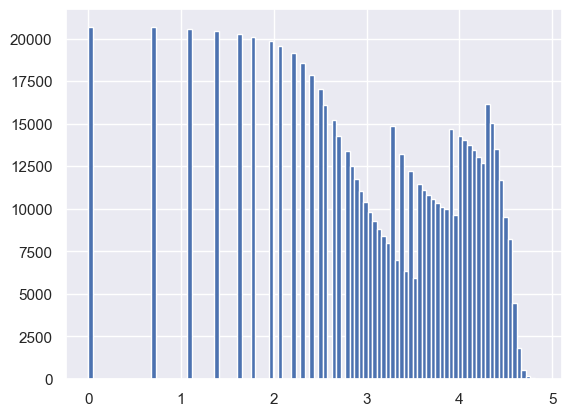

In [268]:
np.log(pitches['pitch_no']).hist(bins = 100)

In [233]:
#  Define X and y for a model to predict pitch number based on mechanics
y = pd.DataFrame([x ** 0.5 for x in pitches['pitch_no']])
X = pitches[features]

In [234]:
X['pitch_type_orig'] = X['pitch_type']

C:\Users\ari\AppData\Local\Temp\ipykernel_24588\2870365771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pitch_type_orig'] = X['pitch_type']


In [235]:
#X['player_name_orig'] = X['player_name']

In [236]:
X = pd.get_dummies(X, columns = ['pitch_type'])

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [239]:
for col in features[:-4]:   
    X_train[f'{col}_avg'] = X_train.groupby(['player_name','pitch_type_orig'])[col].transform('mean')
    avgs = X_train.groupby(['player_name', 'pitch_type_orig'])[col].mean().reset_index()
    merge = X_test.merge(avgs, on = ['player_name','pitch_type_orig'], how = 'left')
    X_test[f'{col}_avg'] = merge[col + '_y']
    X_train[f'{col}_diff'] = X_train[col] - X_train[f'{col}_avg']
    X_test[f'{col}_diff'] = X_test[col] - X_test[f'{col}_avg']    
 #   X_train.drop(columns = [col + '_avg'], inplace = True)   
  #  X_test.drop(columns = [col + '_avg'], inplace = True)

In [240]:
X_train.drop(columns = ['player_name', 'pitch_type_orig'], inplace = True)

In [241]:
X_test.drop(columns = ['player_name', 'pitch_type_orig'], inplace = True)

In [242]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [243]:
combined = pd.concat([X_test, y_test], axis = 1)

In [244]:
combined.dropna(inplace = True)

In [245]:
X_test = combined.iloc[:,:-1]

In [246]:
y_test = combined.iloc[:,-1]

In [247]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((376931, 70), (125604, 70), (376931, 1), (125604,))

In [248]:
y_train = y_train.squeeze()

In [249]:
scaled = X_train.columns[~((X_train.columns.str.contains('pitch_type'))| (X_train.columns.str.contains('player_name')))]

In [254]:
ctx = ColumnTransformer(transformers = [
    ('ss', StandardScaler(),list(scaled))
], remainder = 'passthrough')

In [255]:
ctx

ColumnTransformer(remainder='passthrough',
                  transformers=[('ss', StandardScaler(),
                                 ['vx0', 'vy0', 'vz0', 'release_speed', 'pfx_x',
                                  'pfx_z', 'plate_x', 'plate_z', 'ax', 'ay',
                                  'az', 'release_spin_rate',
                                  'release_extension', 'release_pos_x',
                                  'release_pos_y', 'release_pos_z', 'vz0*2',
                                  'pfx_z*2', 'plate_z*2', 'sz_top', 'sz_bot',
                                  'vx0_avg', 'vx0_diff', 'vy0_avg', 'vy0_diff',
                                  'vz0_avg', 'vz0_diff', 'release_speed_avg',
                                  'release_speed_diff', 'pfx_x_avg', ...])])

In [256]:
X_train = ctx.fit_transform(X_train)
X_test = ctx.transform(X_test)

In [257]:
X_train = pd.DataFrame(X_train, columns = ctx.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = ctx.get_feature_names_out())

In [44]:
#poly = PolynomialFeatures()
#X_train = poly.fit_transform(X_train)
#X_test = poly.transform(X_test)

In [45]:
#X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
#X_test = pd.DataFrame(X_test, columns = poly.get_feature_names_out())

In [258]:
base = [np.mean(y_train)] * len(y_test)

In [259]:
mean_squared_error(y_test, base, squared = False)

2.379736970543924

In [260]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((376931, 70), (125604, 70), (376931,), (125604,))

In [726]:
y_train = y_train.squeeze()

In [261]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mean_squared_error(y_train, lr.predict(X_train), squared = False), mean_squared_error(y_test, lr.predict(X_test), squared = False)

(2.32330515104376, 3.3503544201432476)

In [264]:
rf = RandomForestRegressor(max_depth = 20, max_leaf_nodes = 50, n_estimators = 100, n_jobs = -1)
rf.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
mean_squared_error(y_train, rf.predict(X_train), squared = False), mean_squared_error(y_test, rf.predict(X_test), squared = False)

In [64]:
X_train.shape

(528069, 73)

In [116]:
from tensorflow.keras import backend as K

In [121]:
from tensorflow.keras.callbacks import EarlyStopping

In [226]:
K.clear_session()

In [227]:
model = Sequential()
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics = ['mse'])
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 100, callbacks = EarlyStopping(patience = 5), batch_size = 1024)
model.save('model_starters_1',save_format = 'tf')
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared = False)
plt.scatter(y = np.exp(y_pred), x = np.exp(y_test))
plt.ylim(0,120)
K.clear_session()

Epoch 1/100
369/369 [==============================] - 14s 35ms/step - loss: 5.7698 - mse: 5.7698 - val_loss: 21.6653 - val_mse: 21.6653
Epoch 2/100
369/369 [==============================] - 12s 34ms/step - loss: 4.6634 - mse: 4.6634 - val_loss: 12.6138 - val_mse: 12.6138
Epoch 3/100
369/369 [==============================] - 11s 31ms/step - loss: 4.5654 - mse: 4.5654 - val_loss: 7.5487 - val_mse: 7.5487
Epoch 4/100
369/369 [==============================] - 12s 31ms/step - loss: 4.5022 - mse: 4.5022 - val_loss: 5.5925 - val_mse: 5.5925
Epoch 5/100
369/369 [==============================] - 11s 31ms/step - loss: 4.4473 - mse: 4.4473 - val_loss: 5.5848 - val_mse: 5.5848
Epoch 6/100
369/369 [==============================] - 12s 31ms/step - loss: 4.3919 - mse: 4.3919 - val_loss: 5.6622 - val_mse: 5.6622
Epoch 7/100
368/369 [============================>.] - ETA: 0s - loss: 4.3505 - mse: 4.3505

KeyboardInterrupt: 

In [123]:
model = Sequential()
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics = ['mse'])
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 100, callbacks = EarlyStopping(patience = 5), batch_size = 1024)
model.save('model_2',save_format = 'tf')
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared = False)
plt.scatter(y = np.exp(y_pred), x = np.exp(y_test))
plt.ylim(0,120)
K.clear_session()

Epoch 1/100
516/516 [==============================] - 37s 70ms/step - loss: 1.5912 - mse: 1.5912 - val_loss: 1.7554 - val_mse: 1.7554
Epoch 2/100
516/516 [==============================] - 38s 74ms/step - loss: 1.3463 - mse: 1.3463 - val_loss: 1.6899 - val_mse: 1.6899
Epoch 3/100
516/516 [==============================] - 39s 76ms/step - loss: 1.2785 - mse: 1.2785 - val_loss: 1.7740 - val_mse: 1.7740
Epoch 4/100
516/516 [==============================] - 39s 75ms/step - loss: 1.2332 - mse: 1.2332 - val_loss: 1.5481 - val_mse: 1.5481
Epoch 5/100
516/516 [==============================] - 39s 76ms/step - loss: 1.2143 - mse: 1.2143 - val_loss: 1.5029 - val_mse: 1.5029
Epoch 6/100
516/516 [==============================] - 39s 75ms/step - loss: 1.2065 - mse: 1.2065 - val_loss: 1.4248 - val_mse: 1.4248
Epoch 7/100
516/516 [==============================] - 38s 73ms/step - loss: 1.2018 - mse: 1.2018 - val_loss: 1.4320 - val_mse: 1.4320
Epoch 8/100
516/516 [==============================] - 

KeyboardInterrupt: 

In [ ]:
model = Sequential()
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics = ['mse'])
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 100, callbacks = EarlyStopping(patience = 5), batch_size = 32)
model.save('model_3_1024*1_batch_32',save_format = 'tf')
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared = False)
plt.scatter(y = np.exp(y_pred), x = np.exp(y_test))
plt.ylim(0,120)
K.clear_session()

In [229]:
K.clear_session()

In [230]:
model = Sequential()
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics = ['mse'])
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 100, callbacks = EarlyStopping(patience = 5), batch_size = 1024)
model.save('model_starters_1024*1_32*7_batch_1024',save_format = 'tf')
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared = False)
plt.scatter(y = np.exp(y_pred), x = np.exp(y_test))
plt.ylim(0,120)
K.clear_session()

Epoch 1/100
369/369 [==============================] - 18s 42ms/step - loss: 6.3927 - mse: 6.3927 - val_loss: 26.7022 - val_mse: 26.7022
Epoch 2/100
369/369 [==============================] - 13s 35ms/step - loss: 4.5721 - mse: 4.5721 - val_loss: 12.5729 - val_mse: 12.5729
Epoch 3/100
369/369 [==============================] - 13s 34ms/step - loss: 4.4527 - mse: 4.4527 - val_loss: 7.5887 - val_mse: 7.5887
Epoch 4/100
369/369 [==============================] - 12s 33ms/step - loss: 4.3603 - mse: 4.3603 - val_loss: 6.7805 - val_mse: 6.7805
Epoch 5/100
369/369 [==============================] - 12s 32ms/step - loss: 4.2932 - mse: 4.2932 - val_loss: 8.0151 - val_mse: 8.0151
Epoch 6/100
369/369 [==============================] - 13s 34ms/step - loss: 4.2611 - mse: 4.2611 - val_loss: 7.7993 - val_mse: 7.7993
Epoch 7/100
369/369 [==============================] - 12s 32ms/step - loss: 4.2217 - mse: 4.2217 - val_loss: 7.7179 - val_mse: 7.7179
Epoch 8/100
369/369 [==============================

KeyboardInterrupt: 

In [393]:
#  Dummify pitch type, but keep original for further preprocessing
X['pitch_type_orig'] = X['pitch_type']
X = pd.get_dummies(X, columns = ['pitch_type'])

C:\Users\rob\AppData\Local\Temp\ipykernel_9140\2939201450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pitch_type_orig'] = X['pitch_type']
